In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from bowl_data_set import BowlDataset
import pandas as pd
from random import shuffle

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from bowl_config import BowlConfig

config = BowlConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        500
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               200
MEAN_PIXEL                     [41.5 41.5 41.5]
MINI_MASK_SHAPE                (56, 56)
NAME                           Bowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE   

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_bowl()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
dataset_dir = "stage1_train"
augment_dir = "stage1_augment_train"
num_per_image = 3

img_ids = next(os.walk(dataset_dir))[1]
# x is your dataset
np.random.seed(0)
np.random.shuffle(img_ids)
train_len = int(len(img_ids) * 0.75)
train_img_ids, val_img_ids = img_ids[:train_len], img_ids[train_len:]

train_id_set = set(train_img_ids)
augment_img_ids = [img_id for img_id in next(os.walk(augment_dir))[1] if img_id.split('_')[0] in train_id_set]
assert len(augment_img_ids) == len(next(os.walk(augment_dir))[1])
# Training dataset
dataset_train = BowlDataset()
dataset_train.load_bowl(dataset_dir, train_img_ids)

# create augment data.
# dataset_train.augment(augment_dir, num_per_image)

#load pre-created augment image.
dataset_train.load_bowl(augment_dir, augment_img_ids)
shuffle(dataset_train.image_info)
dataset_train.prepare()

# Validation dataset
dataset_val = BowlDataset()
dataset_val.load_bowl(dataset_dir, val_img_ids)
dataset_val.prepare()

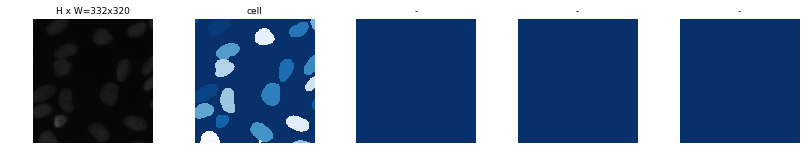

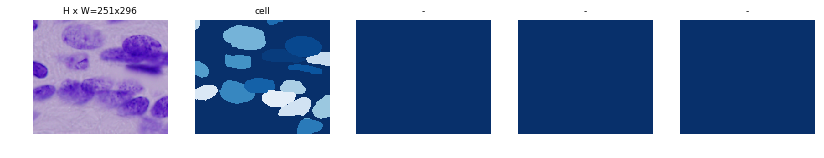

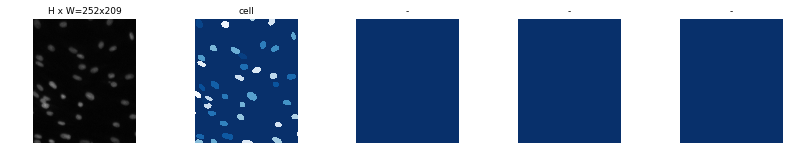

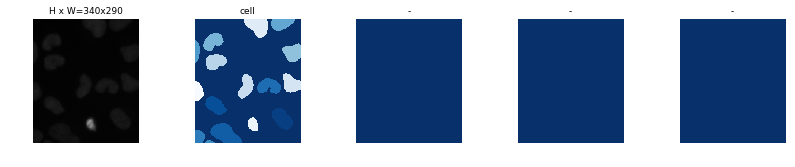

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id, gray_scale=False)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers.

In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/hyperminer02/Kaggle_Bowl_2018/mask_rcnn/logs/bowl20180406T0013/mask_rcnn_bowl_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDis

/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


  8/100 [=>............................] - ETA: 5:03 - loss: 5.2445 - rpn_class_loss: 0.8706 - rpn_bbox_loss: 0.3621 - mrcnn_class_loss: 1.5192 - mrcnn_bbox_loss: 1.0220 - mrcnn_mask_loss: 1.4706

/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


 28/100 [=======>......................] - ETA: 4:13 - loss: 2.9262 - rpn_class_loss: 0.4858 - rpn_bbox_loss: 0.3941 - mrcnn_class_loss: 0.6034 - mrcnn_bbox_loss: 0.6209 - mrcnn_mask_loss: 0.8219

Process Process-3:
Traceback (most recent call last):
  File "/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/keras/utils/data_utils.py", line 677, in _data_generator_task
    generator_output = next(self._generator)
  File "/home/hyperminer02/Kaggle_Bowl_2018/mask_rcnn/model.py", line 1647, in data_generator
    gt_class_ids, gt_boxes, config)
  File "/home/hyperminer02/Kaggle_Bowl_2018/mask_rcnn/model.py", line 1445, in build_rpn_targets
    gt_iou_argmax = np.argmax(overlaps, axis=0)
  File "/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 1004, in argmax
    return _wrapfunc(a, 'argmax', axis=axis, out=out)
  File "/home/hyperminer02/ana

KeyboardInterrupt: 

# Save train head result

In [9]:
class InferenceConfig(BowlConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_NMS_THRESHOLD = 0.3
    RPN_NMS_THRESHOLD = 0.7

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hyperminer02/2018_Data_Science_Bowl/Mask_RCNN/logs/bowl20180405T1404/mask_rcnn_bowl_0100.h5


In [10]:
test_dir = "stage1_test"
import skimage
img_ids = next(os.walk(test_dir))[1]
new_test_ids = []
rles = []
for img_id in img_ids:
    image = skimage.io.imread(os.path.join(test_dir, img_id, "images", "{}.png".format(img_id)))[:,:, :3]
    results = model.detect([image], verbose=0)
    r = results[0]
    rle = utils.masks_to_rles(r['masks'], r['class_ids'], r['rois'], overlap_threshold=0.1)
    rles.extend(rle)
    new_test_ids.extend([img_id] * len(rle))

## export to submit csv file

In [11]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-train-head.csv', index=False)

# Train All layers

In [12]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [13]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/hyperminer02/2018_Data_Science_Bowl/Mask_RCNN/logs/bowl20180405T1803/mask_rcnn_bowl_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b 

/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/20
100/100 [==============================] - 172s 2s/step - loss: 10.1165 - rpn_class_loss: 2.0334 - rpn_bbox_loss: 5.5892 - mrcnn_class_loss: 0.1459 - mrcnn_bbox_loss: 1.4175 - mrcnn_mask_loss: 0.9304 - val_loss: 3.8524 - val_rpn_class_loss: 0.4620 - val_rpn_bbox_loss: 1.7503 - val_mrcnn_class_loss: 0.1308 - val_mrcnn_bbox_loss: 0.7423 - val_mrcnn_mask_loss: 0.7670
Epoch 2/20
100/100 [==============================] - 158s 2s/step - loss: 3.3642 - rpn_class_loss: 0.5225 - rpn_bbox_loss: 1.4242 - mrcnn_class_loss: 0.1013 - mrcnn_bbox_loss: 0.6087 - mrcnn_mask_loss: 0.7074 - val_loss: 2.7748 - val_rpn_class_loss: 0.2523 - val_rpn_bbox_loss: 1.1295 - val_mrcnn_class_loss: 0.1274 - val_mrcnn_bbox_loss: 0.5957 - val_mrcnn_mask_loss: 0.6700
Epoch 3/20
100/100 [==============================] - 153s 2s/step - loss: 2.5554 - rpn_class_loss: 0.3357 - rpn_bbox_loss: 1.0187 - mrcnn_class_loss: 0.0834 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.6445 - val_loss: 2.2289 - val_rpn_class_

In [14]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_bowl.h5")
# model.keras_model.save_weights(model_path)

In [15]:
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/hyperminer02/2018_Data_Science_Bowl/Mask_RCNN/logs/bowl20180405T1803/mask_rcnn_bowl_0020.h5


Processing 1 images
image                    shape: (520, 696, 3)         min:   15.00000  max:  221.00000
molded_images            shape: (1, 512, 512, 3)      min:  -48.20000  max:  181.40000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


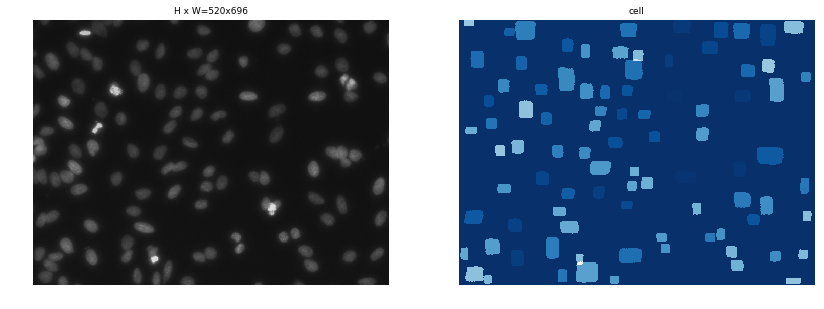

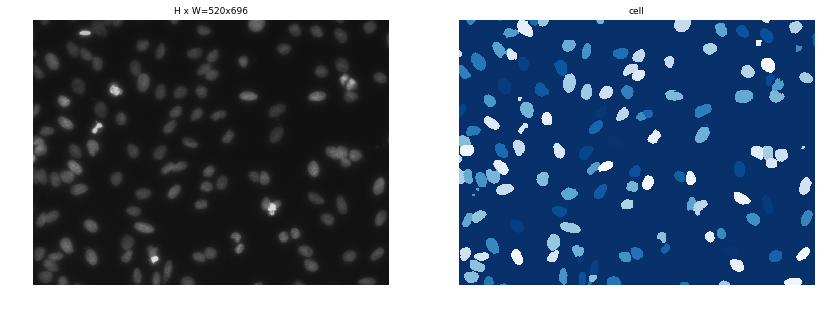

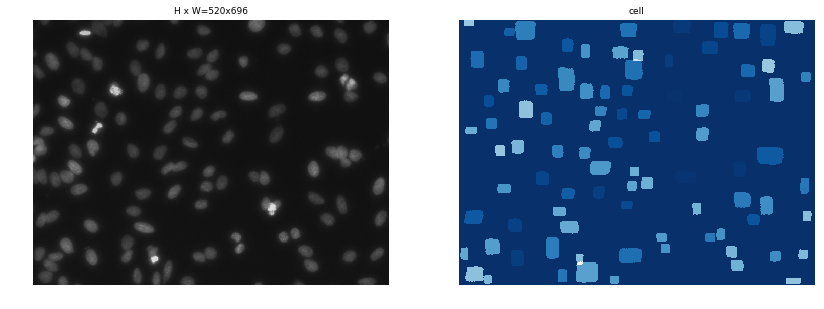

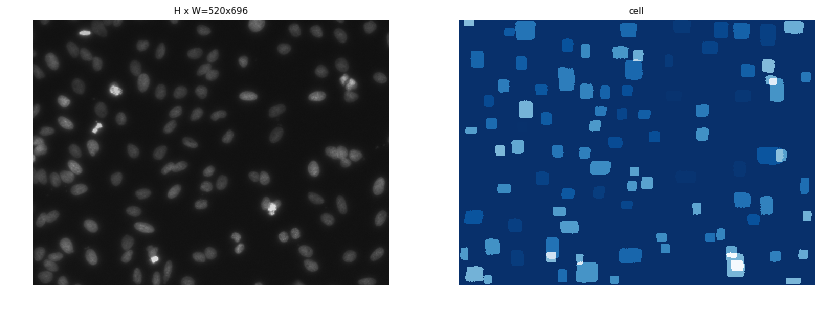

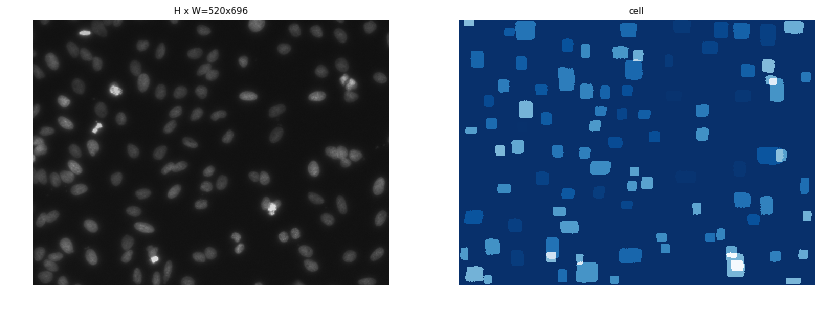

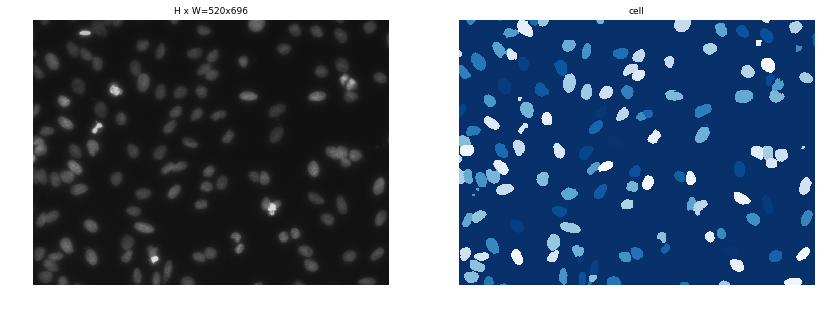

In [16]:
image_id = np.random.choice(dataset_val.image_ids, 1)[0]
image = dataset_val.load_image(image_id, gray_scale=False)
mask, class_ids = dataset_val.load_mask(image_id)

results = model.detect([image], verbose=1)

r = results[0]

masks = utils.nms_masks(r['masks'], r['class_ids'], r['rois'], overlap_threshold=0.1)

visualize.display_top_masks(image, masks, [1 for _ in range(masks.shape[-1])], dataset_train.class_names, limit=1)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)

visualize.display_top_masks(image, masks, [1 for _ in range(masks.shape[-1])], dataset_train.class_names, limit=1)
visualize.display_top_masks(image, r['masks'], r['class_ids'], dataset_train.class_names, limit=1)

visualize.display_top_masks(image, r['masks'], r['class_ids'], dataset_train.class_names, limit=1)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names,limit=1)



## Load test set and run Run-length encoding

In [17]:
test_dir = "stage1_test"
import skimage
img_ids = next(os.walk(test_dir))[1]
new_test_ids = []
rles = []
for img_id in img_ids:
    image = skimage.io.imread(os.path.join(test_dir, img_id, "images", "{}.png".format(img_id)))[:,:, :3]
    results = model.detect([image], verbose=0)
    r = results[0]
    rle = utils.masks_to_rles(r['masks'], r['class_ids'], r['rois'], overlap_threshold=0.1)
    rles.extend(rle)
    new_test_ids.extend([img_id] * len(rle))

## export to submit csv file

In [18]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-train-head.csv', index=False)

In [18]:
lab_img.max()

98

In [20]:
m.min()

0

In [11]:
dataset_dir = "stage1_train"
import skimage
img_ids = next(os.walk(dataset_dir))[1]
num_pixels = []
for img_id in img_ids:
    mask_dir = os.path.join(dataset_dir, img_id, "masks")
    mask_list = next(os.walk(mask_dir))[2]
    for mask_file in mask_list:
        image = skimage.io.imread(os.path.join(mask_dir, mask_file))
        image = image & 1
        num_pixels.append(np.sum(image))
num_pixels = np.array(num_pixels)

In [13]:
num_pixels.max()

11037

In [14]:
num_pixels.min()

21

In [6]:
np.stack(mask, 2).shape

(256, 76, 256)

In [7]:
x = np.ones((3,3))

In [8]:
np.expand_dims(x, axis=-1).shape

(3, 3, 1)